# Amazon Review Data Exploration

Download the amazon review dataset:
https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt

SAMPLE CONTENT:
https://s3.amazonaws.com/amazon-reviews-pds/tsv/sample_us.tsv
https://s3.amazonaws.com/amazon-reviews-pds/tsv/sample_fr.tsv

|DATA COLUMNS:| Description |
|-------------|--------|
|marketplace       | 2 letter country code of the marketplace where the review was written. |
|customer_id       | Random identifier that can be used to aggregate reviews written by a single author. |
|review_id         | The unique ID of the review. |
|product_id        | The unique Product ID the review pertains to. In the multilingual dataset the reviews                    for the same product in different countries can be grouped by the same product_id. |
|product_parent    | Random identifier that can be used to aggregate reviews for the same product. |
|product_title     | Title of the product. |
|product_category  | Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). |
|star_rating       | The 1-5 star rating of the review. |
|helpful_votes     | Number of helpful votes. |
|total_votes       | Number of total votes the review received. |
|vine              | Review was written as part of the Vine program. |
|verified_purchase | The review is on a verified purchase. |
|review_headline   | The title of the review. |
|review_body       | The review text. |
|review_date       | The date the review was written. |

DATA FORMAT
Tab ('\t') separated text file, without quote or escape characters.
First line in each file is header; 1 line corresponds to 1 record.


For speed analysis, I will be loading a subset of the data here - orginal file has 9 million entries. The original Amazon review file is ordered by date. We took 1 out of every 50 lines in the original file to create the dataset we are using here. 

In [6]:
# import sibling utilities
import sys
sys.path.append('../..')

import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import logging

logging.basicConfig(level=logging.INFO)

import util.file_util as fu

# global variables
COLUMNS_TO_DROP=["marketplace", "vine", "verified_purchase"]
USE_PANDAS=True
SEPERATOR=","

DATA_DIR = "../../dataset/amazon_reviews"

# full 9mil Wireless reviews - not enough memory locally to do this
ORIG_FILE_WIRELESS=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00.tsv"


# Reading File With Pandas

## Unfortunately, this method does not seem to work. It starts merging multiple lines into the healine column of the dataframe

In [7]:

# if USE_PANDAS == True:

#     # pandas is doing something weird. The lines that says have bad number of columns actually have the right columns???
#     reviews = pd.read_csv(DATA_FILE, sep=SEPERATOR, 
#                              parse_dates=["review_date"], 
#                              warn_bad_lines=True, 
#                              error_bad_lines=False)
#     reviews.info()

## pandas for some reason does not read the amazon TSV correctly and starts to merge lines together. Originally, I tried this method to construct the DataFrame but this proved to be very inefficient and slow. Took about 30 minutes to create a DF that had about 100k entries

commenting out since we won't be needing this

In [8]:
# not quite ready
# if USE_PANDAS == False:

#     columns = ["marketplace", "customer_id", "review_id", "product_id",
#               "product_parent", "product_title", "product_category", 
#               "star_rating", "helpful_votes", "total_votes", "vine",
#               "verified_purchase", "review_headline", "review_body",
#               "review_date"]
#     reviews = pd.DataFrame(columns = columns)
#     count = 0
#     with open(DATA_FILE, "r") as file:
#         for line in file:
#             if len(line) > 0:
#                 line = line.rstrip("\n")
#                 # skip the header
#                 if count > 0:
#                     splitted = line.split("\t")
#                     reviews = reviews.append(pd.Series(splitted, index=columns), 
#                                    ignore_index=True)
#                 count += 1
#                 if count % 10000 == 0:
#                     print(f"processed {count}")

#     print(len(reviews))

    
# reviews.info()

In [9]:
# if we don't use pandas, we have to set datatypes for the columns
# if USE_PANDAS == False:
#     reviews = reviews.astype({
#         "review_date": np.datetime64,
#         "star_rating": np.int64,
#         "helpful_votes": np.int64,
#         "total_votes": np.int64
#     })
# reviews.info()

## Finally, wrote a utility to convert the file from TSV to CSV by stripping newlines and replacing tabs with , without dataframe seems to be more efficient

Code for this has been put into a utility function in file_util.py

In [10]:
# sample original file to create smaller files with different sampling rates to inspect
from util.file_samplers import SimpleSampler

from util.file_util import convert_tsv_to_csv

DATA_FILE_100k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-100k.csv"

# already ran this
fu.convert_tsv_to_csv(ORIG_FILE_WIRELESS, DATA_FILE_100k, SimpleSampler(90))


DATA_FILE=DATA_FILE_100k

INFO:util.file_util:Converting ../../dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00.tsv to ../../dataset/amazon_reviews/amazon_reviews_us_Wireless_v1_00-100k.csv with sampling <util.file_samplers.SimpleSampler object at 0x7fccc8b03850>


# Now that we have data files we can use Pandas

In [11]:
reviews = pd.read_csv(DATA_FILE, sep=SEPERATOR, 
                         parse_dates=["review_date"])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100022 entries, 0 to 100021
Data columns (total 15 columns):
marketplace          100022 non-null object
customer_id          100022 non-null int64
review_id            100022 non-null object
product_id           100022 non-null object
product_parent       100022 non-null int64
product_title        100022 non-null object
product_category     100022 non-null object
star_rating          100022 non-null int64
helpful_votes        100022 non-null int64
total_votes          100022 non-null int64
vine                 100022 non-null object
verified_purchase    100022 non-null object
review_headline      100020 non-null object
review_body          100010 non-null object
review_date          100022 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(9)
memory usage: 11.4+ MB


In [12]:
# looks like sometimes we have reviews with no body, no headline, and no review dates
# let's drop those rows with missing data
# also drop the following columns since they will always be the same
clean_df = reviews.dropna().drop(COLUMNS_TO_DROP, axis = 1)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100008 entries, 0 to 100021
Data columns (total 12 columns):
customer_id         100008 non-null int64
review_id           100008 non-null object
product_id          100008 non-null object
product_parent      100008 non-null int64
product_title       100008 non-null object
product_category    100008 non-null object
star_rating         100008 non-null int64
helpful_votes       100008 non-null int64
total_votes         100008 non-null int64
review_headline     100008 non-null object
review_body         100008 non-null object
review_date         100008 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 9.9+ MB


## Most Products Only have 1 or 2 reviews

Amazon have variations of products under product_parent. If we group by that field, we can see how many unique products we have

There are 50k unique products out of 100k reviews

75% of our products have 2 or less reviews.

In [13]:
# how many products do we have?
grouped = clean_df.groupby("product_parent")

There are (50182 unique products out of 100008)


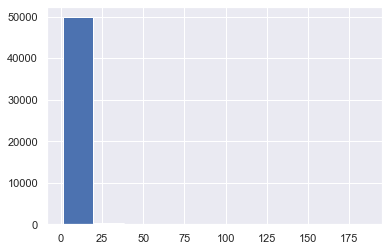

In [14]:
unique_products = len(grouped)
unique_product_percentage = round(unique_products / len(clean_df) * 100)
print(f"There are ({unique_products} unique products out of {len(clean_df)})")

grouped.size().hist()

In [15]:
quantile_list = [0., .25, .75, 1.]
quantiles = grouped.size().quantile(quantile_list)
quantiles

0.00      1.0
0.25      1.0
0.75      2.0
1.00    186.0
dtype: float64

                count
product_parent       
13657               1
35475               1
87058               1
88425               3
110850              1
...               ...
999862592           2
999907274           1
999915424          11
999975338           1
999992994           1

[50182 rows x 1 columns]


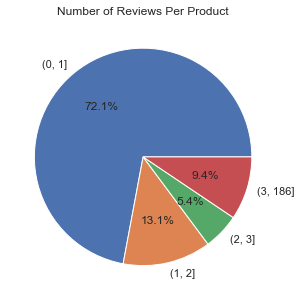

In [54]:
# trying some type of binning
products_df = pd.DataFrame(grouped.size(), columns=["count"])
products_df = products_df.assign(bin=lambda x: pd.cut(x["count"], [0, 1, 2, 3, x["count"].max()]))

product_review_df = pd.DataFrame(products_df.groupby("bin").size(), columns=["count"]).reset_index()
product_review_df["percent"] = product_review_df["count"] / product_review_df["count"].sum() * 100
product_review_df

f, a = plt.subplots(1, 1, figsize=(5, 5))
_ = plt.pie(product_review_df.percent, labels=product_review_df.bin, autopct='%1.1f%%')
_ = plt.title("Number of Reviews Per Product")


# Reviews By Month and Days

We have the least number of reviews in September, October, November and most reviews from January, July, and August

Most reviews are done at the beginning of the week. There are less reviews on the weekends (Saturday/Sunday)

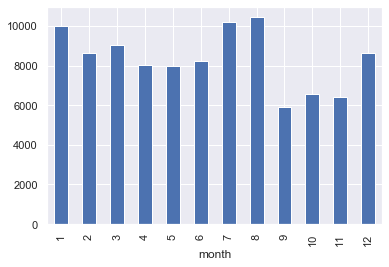

In [41]:
# distribution of months

df = clean_df
df["month"] = df.review_date.dt.month
df.groupby("month").size().plot(kind='bar')

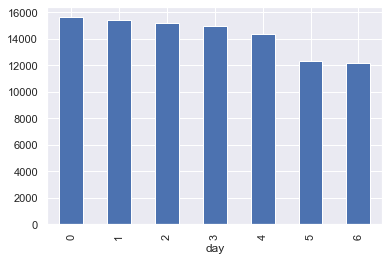

In [18]:
# distribution of days of the week
# distribution of months

df = clean_df
df["day"] = df.review_date.dt.dayofweek
df.groupby("day").size().plot(kind='bar')

# Review Stars Distribution

Amazon reviews are heavily skewed toward 5 stars. Next is 4-1. Rarely do people rate 2 and 3

* 2-star only has about 6% of reviews
* 3-star only has about 9% of reviews

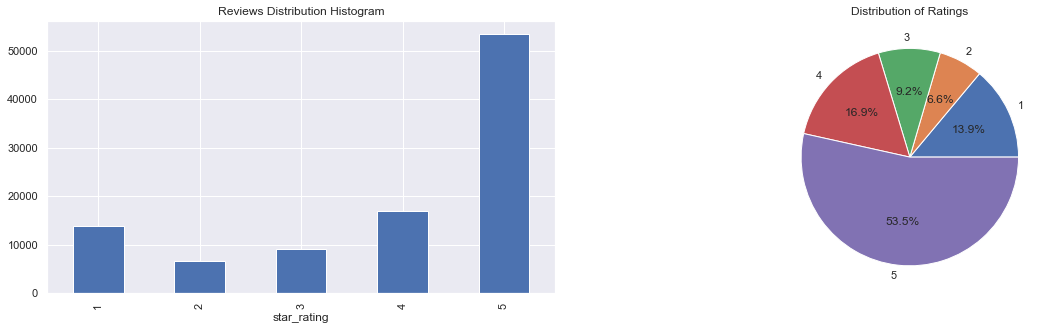

In [19]:
f, a = plt.subplots(1, 2, figsize=(20, 5))

# let's look at distribution of stars
_ = clean_df.groupby("star_rating").size().plot(kind='bar', ax=a[0])
_ = a[0].set_title("Reviews Distribution Histogram")
# reviews lean heavily towards 5-stars


ratings_summary = pd.DataFrame(clean_df.groupby("star_rating").size(), columns=["count"]).reset_index()
ratings_summary["percent"] = ratings_summary["count"] / ratings_summary["count"].sum() * 100

# clean_df.groupby("star_rating").size().apply(lambda x: 100 * x / float(x.sum()))

_ = a[1].pie(ratings_summary.percent, labels=ratings_summary.star_rating, autopct='%1.1f%%')
_ = a[1].set_title("Distribution of Ratings")

# Votes - Helpful or Not

Customer generally only vote when a review is helpful.

Again this is heavily imbalanced. only 27% of reviews have votes at all. 

Around 80% of reviews that are voted on, gets helpful votes

In [20]:
# let's look at what percentage of reviews have votes
has_votes_count = len(clean_df[(clean_df.total_votes > 0)])
has_votes_percentage = round(has_votes_count / len(clean_df), 2) * 100
print(f"{has_votes_percentage} percent "\
      f"({has_votes_count}) has votes")
# let's look at what percentage of reviews have votes
helpful_votes_count = len(clean_df[(clean_df.helpful_votes > 0)])
helpful_votes_percentage = round(helpful_votes_count / len(clean_df), 2) * 100
print(f"{helpful_votes_percentage} percent "\
            f"({helpful_votes_count}) has helpful votes")
         
print(f"{round(helpful_votes_count / has_votes_count, 2) * 100} percent of all voted reviews are helpful")


# let's look at distribution of total_votes
clean_df.describe()
# looks like most do not have any votes

27.0 percent (26598) has votes
21.0 percent (20703) has helpful votes
78.0 percent of all voted reviews are helpful


,customer_id,product_parent,star_rating,helpful_votes,total_votes,month,day
count,1.000080e+05,1.000080e+05,100008.000000,100008.000000,100008.000000,100008.000000,100008.000000
mean,2.545804e+07,5.005082e+08,3.894068,0.825734,1.090473,6.235291,2.826254
std,1.578201e+07,2.880786e+08,1.459667,6.606973,7.356052,3.441638,1.969111
min,1.031700e+04,1.365700e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.232722e+07,2.511852e+08,3.000000,0.000000,0.000000,3.000000,1.000000
50%,2.340914e+07,4.999781e+08,5.000000,0.000000,0.000000,6.000000,3.000000
75%,4.030358e+07,7.485788e+08,5.000000,0.000000,1.000000,9.000000,4.000000
max,5.309587e+07,9.999930e+08,5.000000,495.000000,601.000000,12.000000,6.000000


# Review Body

* minimum length of review is 1 word
* maximum length of review is 8k words
* 70% of our reviews have 50 words or less
* 90% of our reviews have 100 words or less

In [36]:
df = clean_df

# now let's look at distribution of wc for review body
df["review_body_wc"] = df["review_body"].apply(lambda x: len(str(x).split()))
df["review_body_wc"].quantile([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])

0.0       1.0
0.1       4.0
0.2       9.0
0.3      18.0
0.4      22.0
0.5      27.0
0.6      35.0
0.7      46.0
0.8      65.0
0.9     107.0
1.0    8147.0
Name: review_body_wc, dtype: float64

In [38]:
max_wc = df.review_body_wc.max()
min_wc = df.review_body_wc.min()
print(f"min review wc: {min_wc}\nmax review wc: {max_wc}")

min review wc: 1
max review wc: 8147
